## This project's goal is the extraction of text and named entities from pdf files and images, leveraging open source trained models such as spacy NER and Google Tesseract OCR. The pipeline can be summarized as such:
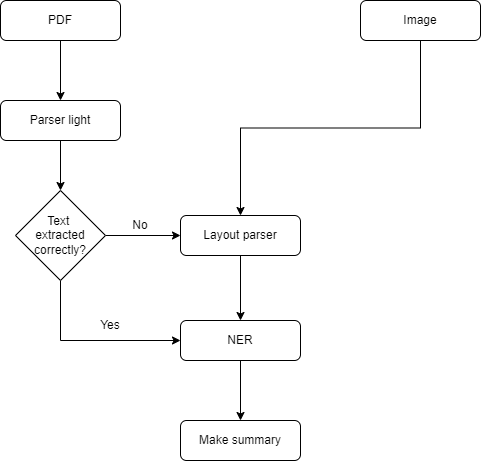

#### Download and imports

In [ ]:
!pip install pdf2image
!pip install layoutparser
!pip install pdfminer
!pip install pillow
!pip install transformers
!pip install spacy-transformers
!python -m spacy download en_core_web_lg
!pip install layoutparser torchvision && pip install "detectron2@git+https://github.com/facebookresearch/detectron2.git@v0.5#egg=detectron2"
!sudo apt install tesseract-ocr
!pip install extract
!apt-get install poppler-utils
!pip install pytesseract

In [1]:
import re
import spacy
from string import punctuation
from spacy.training import offsets_to_biluo_tags
import pdf2image
import numpy as np
import layoutparser as lp
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.pdfpage import PDFPage
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from PIL import Image
import os
import itertools as it
import io
import pandas as pd
import pytesseract
import skimage.io

## The code is structured in functions, they are divided into three main tasks:

#### Read text

In [2]:
def read_path_to_bytes(path: str):
    """
    Input:
        File path, supported extentions: .pdf and all PIL supported extensions
    Returns:
        Bytes-likes object
    """
    extension = os.path.splitext(path)[1]
    if extension == ".pdf":
        file_obj = open(path,"rb")
    else:
        file_obj = Image.open(path)

    return file_obj 

def pdf2txt(inPDFfile):
    """
    Extract text from PDF file using pdfminer
    """
    fp = open(inPDFfile, 'rb')
    resMgr = PDFResourceManager()
    retData = io.StringIO()
    TxtConverter = TextConverter(resMgr, retData, laparams=LAParams())
    interpreter = PDFPageInterpreter(resMgr, TxtConverter)
    for page in PDFPage.get_pages(fp):
        interpreter.process_page(page)
    txt = retData.getvalue()
    return txt


def parser_light(inFile, doc_type, model = "en_core_web_lg"):
    """
    Read pdf and uses clean text functions to extract clean text.
    If the parsed text is less than half the total text or pdf2txt is not able to read the document (e.g. images or pdf scans) return None.
    """
    
    text = pdf2txt(inFile)
    initial_length = len(text)
    text = clean_text(text)
    final_length = len(text)

    # If more than 50% of the text has beeen removed return None
    if final_length/initial_length > 0.5:
        return text
    else:
        return None


def layout_parser(inFile, doc_type):
    """
    pdf_layout_parser:
        - Converts PDF to an image.
        - Applies layout classification on the image.
        - Extracts text from the layouts of interest (title, text and list) using Tesseract OCR.
        - Clean text and returns the text.
    """
    # Convert image in numpy array
    if doc_type == ".pdf":
        imgs = [np.asarray(i) for i in pdf2image.convert_from_path(inFile)]
    elif doc_type == ".image":
        inFile = read_path_to_bytes(inFile)
        img = inFile.convert("RGB")
        imgs = [np.array(img)]

    # Select Detectron2 layout model (type of layouts to detect)                   
    model = lp.Detectron2LayoutModel('lp://PubLayNet/mask_rcnn_X_101_32x8d_FPN_3x/config',
                                     extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.5],
                                     label_map={0: "Text", 1: "Title", 2: "List", 3:"Table", 4:"Figure"})

    # Apply layout model to pages    
    layout_result = []
    try:
        for img in imgs:
            layout_result.append(model.detect(img))
    except:
        print("Coudn't read image.", img.shape)

    # The layout parser model sometimes detects the same layout multiple times leading to the repetition of text,
    # to overcome this problem I select only the layouts that do not overlap
    text_blocks = []
    # For each layout check that it doesn't overlap with each other layout in the same page
    for i in range(len(imgs)):
        overlap = []
        for box1, box2 in it.combinations(layout_result[i], 2):
            # Select only Text, List and Title layouts (the other type of layouts don't contain text)
            if (box1.type == 'Text' or box1.type == 'List' or box1.type == 'Title') and (box2.type == 'Text' or box2.type == 'List' or box2.type == 'Title'):
                coos = []
                coos.extend(list(box1.coordinates))
                coos.extend(list(box2.coordinates))
                inter, A1, A2 = areaInter(coos)
                # Consider overlapped if the intersection between two layouts is greater than 50%
                if inter/A1 > 0.5:
                    overlap.append(layout_result[i].index(box1))
                if inter/A2 > 0.5:
                    overlap.append(layout_result[i].index(box2))
               
        # Create a page with all the layouts that are not overlapped
        page_clean = []
        for k,h in enumerate(layout_result[i]):
            if k not in overlap and (h.type == 'Text' or h.type == 'List' or h.type == 'Title'):
                page_clean.append(h)
        text_blocks.append(lp.Layout(page_clean))
        
    image_width = len(imgs[0][0])
    text = []
    
    # Order the layout based on their coordinates and ID
    for i in range(len(imgs)):
        # Sort element ID of the left column based on y1 coordinate
        left_interval = lp.Interval(0, image_width/2, axis='x').put_on_canvas(imgs[i])
        left_blocks = text_blocks[i].filter_by(left_interval, center=True)._blocks
        left_blocks.sort(key = lambda b:b.coordinates[1])
    
        # Sort element ID of the right column based on y1 coordinate
        right_blocks = [b for b in text_blocks[i] if b not in left_blocks]
        right_blocks.sort(key = lambda b:b.coordinates[1])
    
        # Sort the overall element ID starts from left column
        text_blocks[i] = lp.Layout([b.set(id = idx) for idx, b in enumerate(left_blocks + right_blocks)])
        
        # Apply OCR on the layouts
        for block in text_blocks[i]:
            # Crop image around the detected layout
            segment_image = (block.pad(left=15, right=15, top=5, bottom=5).crop_image(imgs[i]))
            text_new = pytesseract.image_to_string(segment_image)
            text += [text_new]
    
    # Clean text
    if len(text)>0:
        text = " ".join(text)
        text = clean_text(text)
        return text
    else:
        return ""


def areaInter(c):
    """
    Auxiliary function for layout parser.
    Returns the intersection of two rectangles. Used to ignore overlapped text in layout parser.
    Parameters:
    ----------
    c : list of coordinates of two rectangles
    "i" is the bottom left corner, "f" the upper right corner of the rectangles, "1" and "2" are the two rectangles, x and y the coordinates
    c = (x1i,y1i,x1f,y1f,x2i,y2i,x2f,y2f)

    Returns:
    -------
    inter : intersection surface
    a1 : area of 1st rectangle
    a2 : area of 2nd rectangle
    """
    # Compute surfaces of each rectangle
    a1=(c[2]-c[0])*(c[3]-c[1])
    a2=(c[6]-c[4])*(c[7]-c[5])
    # If rectangles do not overlap return 0
    if max(c[0],c[4])>min(c[2],c[6]) or max(c[1],c[5])>min(c[3],c[7]):
        return 0, a1, a2
    # Else return overlapped surface
    else:
        inter = (min(c[2],c[6])-max(c[0],c[4])) * (min(c[3],c[7])-(max(c[1],c[5])))
        return inter, a1, a2


def parser(path, doc_type):
    """
    Reads an image or a pdf and returns the text using the functions previously defined.
    First apply a ligher parser, if it fails apply the layout parser.
    """
    print("Starting light parser\n")
    # Use regex parser (only usable on structured pdf)
    text = None
    if doc_type == ".pdf":
      text = parser_light(path, doc_type=doc_type)
    # If not enough text is extracted this way use the layout parser (slower method)
    if text is None:
        print("Starting layout parser\n")
        text = layout_parser(path, doc_type=doc_type)
    return text

#### Clean text

In [3]:
def join_at_dash(text):
    """
    Join the text at "-" when the text splits the words on newlines
    """
    text = re.sub(r"""([a-z]+)-\n+([a-z]+)""", r"\1\2", text)
    text = re.sub(r"""([A-Z]+)-\n+([A-Z]+)""", r"\1\2", text)
    return text

def join_broken_sent(text):
    """
    Join sentences that have been split up by the reading process
    """
    text = re.sub(r"""(\d|\\|\/|-|—|\'|\"|\.)[\n]([a-z]+|\(|\d|\"|\\)""", r"\1\2", text)
    text = re.sub(r"""(\\)[\n]([A-Z]+)""", r"\1\2", text)
    text = re.sub(r"""([a-zA-Z]+|:|,|\d|\\|\/|-|—|\'|\"|\))\s+[\n]([a-zA-Z]+|\(|\d|\"|\\)""", r"\1 \2", text)
    return text

def select_sensible_sent(text, model='en_core_web_lg'):
    """
    Select only sentences that have a meaning (have at least 2 nouns and a verb, start with a capital letter and finis with punctuation)
    """
    spacy_model = spacy.load(model)
    cleaned = []
    # For every paragraph (a paragraph is considered at multiple newlines),
    for element in re.split('\n\n|\n \n|  \n', text):
        doc = spacy_model(element)
        has_noun = 0
        has_verb = 0
        # for every sentence,
        for sent in doc.sents:
            # check if the sentence starts with capital letter or space and ends with punctuation or dot followed by a number (footnotes references).
            if (sent[0].text[0].isupper() or sent[0].text[0].isspace()) and (sent[-1].text[-1] in punctuation or bool(re.match('\.\d',sent[-1].text[-2:]))):
                # Count the number of nouns and verbs
                for token in sent:
                    if token.pos_ in ["NOUN", "PROPN", "PRON"]:
                        has_noun = has_noun + 1
                    elif token.pos_ == "VERB":
                        has_verb = has_verb + 1
        if has_noun > 1 and has_verb > 0:
            cleaned.append(doc.text)
    text = "\n\n".join(cleaned)
    return text


def clean_text(text):
    # Apply functions to clean text 
    text = join_at_dash(text)
    text = join_broken_sent(text)
    text = select_sensible_sent(text)
    return text

#### Text analysis

In [4]:
def apply_NER(text, model):
    # Apply NER model to the text
    doc = model(text)
    tags = offsets_to_biluo_tags(doc, [(e.start_char, e.end_char, e.label_) for e in doc.ents])
    tokens = [token.text for token in doc]

    
    return doc

def make_summary(doc):
    # Make a summary table of entities found
    doc = doc.to_json()
    data = []
    for ent in doc["ents"]:
        data.append([doc["text"][ent["start"]:ent["end"]], ent["label"]])   # Extract entity from span
    df = pd.DataFrame(data, columns=["text", "label"])
    df = df.value_counts().rename_axis(['Entity', 'Type']).reset_index(name='#')
    df = df.sort_values(by=['#', 'Type','Entity'], ascending= False).reset_index().drop(columns=['index'])
    df.index = df.index + 1
    return df

## Let's apply the pipeline on a scientific paper about Second Language Acquisition.

In [5]:
# Read document
path = "/content/Background_to_Second_Language.pdf"
# Extract text
text = parser(path, doc_type=".pdf")
# Print first few lines of text
print(text[:2000])

Starting light parser

Language is at the centre of human life. We use it to express our love or our hates, to achieve our goals and further our careers, to gain artistic satisfaction or simple pleasure, to pray or to blaspheme. Through language we plan our lives  and  remember  our  past;  we  exchange  ideas  and  experiences;  we  form our social and individual identities. Language is the most unique thing about human beings. As the Roman orator Cicero said in 55BC, ‘The one thing in which we are especially superior to beasts is that we speak to each other’.

Some people are able to do some or all of this in more than one language. 
Knowing another language may mean: getting a job; a chance to get educated; 
the ability to take a fuller part in the life of one’s own country or the opportunity to emigrate to another; an expansion of one’s literary and cultural horizons; the expression of one’s political opinions or religious beliefs; the chance to talk to people on a foreign holiday.

In [6]:
# Apply NER
model = spacy.load("en_core_web_lg")
doc = apply_NER(text, model=model)
# Create view
spacy.displacy.render(doc, style="ent", jupyter=True)

In [7]:
# Make a summary for the entities and print the 5 most frequent
summary = make_summary(doc)
print(summary.head())

         Entity      Type  #
1           SLA       ORG  9
2        second   ORDINAL  7
3       English  LANGUAGE  7
4  SLA Research       ORG  3
5         first   ORDINAL  3


## Now we try it with an image, a screenshot of the Wikipedia website.

In [8]:
# Read document
path = "/content/wikipedia.PNG"
# Extract text
text = parser(path, doc_type=".image")

Starting light parser

Starting layout parser



config.yaml?dl=1: 8.19kB [00:02, 3.68kB/s]
model_final.pth?dl=1: 856MB [00:10, 80.6MB/s]                          
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}
/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:99: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-de


>/ () listen) wik-ih-PEE-dee-e or / wiki-/ (@) listen) wik-ee-) is a multilingual free
online encyclopedia written and maintained by a community of volunteers through open collaboratior
and a wiki-based editing system. Its editors are known as Wikipedians. Wikipedia is the largest and
most-read reference work in history.!5] It is consistently one of the 10 most popular websites ranked
by Similarweb and formerly Alexa; as of 2022, Wikipedia was ranked the 7th most popular site. [SI[4] |

is hosted by the Wikimedia Foundation, an American non-profit organization funded mainly through
donations.
 On January 15, 2001, Jimmy Wales and Larry Sanger launched Wikipedia. Sanger coined its name
as a blend of "wiki" and "encyclopedia"./5!5] Wales was influenced by the "spontaneous order" ideas
associated with Friedrich Hayek and the Austrian School of economics after being exposed to these
ideas by Austrian economist and Mises Institute Senior Fellow Mark Thornton.!7] Initially available
only i

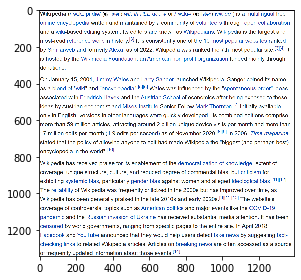

In [9]:
img = skimage.io.imread("/content/wikipedia.PNG")
skimage.io.imshow(img)
print(text)

In [10]:
# Apply NER
model = spacy.load("en_core_web_lg")
doc = apply_NER(text, model=model)
# Create view
spacy.displacy.render(doc, style="ent", jupyter=True)